In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

sns.set(font_scale=1.5, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data

100 points from line 2x + 3 with added normal noise ~ N(0, 0.25)

In [2]:
def noisy_line(a, b, sigma, size, support=(-1, 1)):
    """
    Generate 2D line with added normal error ~ N(0, sigma**2)
    """
    x = np.linspace(*support, num=size)
    errors = scipy.stats.norm.rvs(loc=0, scale=sigma, size=size)
    y = a * x + b + errors
    return x, y

In [3]:
xs, ys = noisy_line(2, 3, 0.25, 100)

y_f = lambda x: 2 * x + 3
y = y_f(xs)

# Gradient Descent

In [4]:
x_in = tf.placeholder(tf.float32, shape=[None])
y_in = tf.placeholder(tf.float32, shape=[None])
learning_rate_eta = tf.placeholder(tf.float32, shape=())

a = tf.get_variable('slope', dtype=tf.float32, shape=())
b = tf.get_variable('intercept', dtype=tf.float32, shape=())
sigma = tf.get_variable('sigma', dtype=tf.float32, shape=())

y_hat = tf.add(tf.multiply(a, x_in), b)
y_hat_noise = y_hat + tf.random_normal(tf.shape(y_hat), mean=0.0, stddev=sigma, dtype=tf.float32)

residual = tf.reduce_mean(tf.square(y_hat - y_in))

negative_log_likelihood = (
    0.5 * tf.log(2 * np.pi * tf.square(sigma)) +
    tf.divide(1, 2 * tf.square(sigma)) * residual
)

mean_squared_error = tf.reduce_mean(tf.square(y_hat_noise - y_in))

optimizer = tf.train.GradientDescentOptimizer(learning_rate_eta)
train_likelihod_op = optimizer.minimize(negative_log_likelihood)

In [5]:
def random_draw(x, y, batch_size):
    indices = np.random.randint(0, len(x), batch_size)
    return x[indices], y[indices]

def train_likelihood(x, y, n_epochs, batch_size, learning_rate):
    saver = tf.train.Saver()
    mse_list = []
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        for epoch in range(n_epochs):
            x_batch, y_batch = random_draw(x, y, batch_size)
            sess.run(train_likelihod_op, feed_dict={x_in: x_batch, y_in: y_batch, learning_rate_eta: learning_rate})
            mse_list.append(sess.run(mean_squared_error, feed_dict={x_in: x_batch, y_in: y_batch}))

        return saver.save(sess, f'./linreg_err_{learning_rate}.ckpt'), mse_list

def predict_likelihood(x, y, save_path):    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_h, y_h_noise, slope, intercept, stdev, mse = sess.run(
            [y_hat, y_hat_noise, a, b, sigma, mean_squared_error], 
            feed_dict={x_in: x, y_in: y}
        )

    return (
        y_h, 
        y_h_noise, 
        float(slope),
        float(intercept),
        abs(float(stdev)),
        float(mse)
    )

def plot_results(x, y, ys, y_hat, y_hat_noise, stdev):
    palette = sns.color_palette('colorblind')
    
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    ax.plot(x, ys, 'o', label='Actual', color=palette[0])
    ax.plot(x, y_hat_noise, 'o', label='Draw', color=palette[2])

    y_err_actual_low = y - 2 * stdev
    y_err_actual_high = y + 2 * stdev

    y_err_low = y_hat - 2 * stdev
    y_err_high = y_hat + 2 * stdev

    ax.plot(xs, y, '-', color=palette[0], alpha=1.0)
    ax.fill_between(xs, y_err_actual_low, y_err_actual_high, color=palette[0], alpha=0.1)

    ax.plot(xs, y_hat, '-', color=palette[2], alpha=1.0)
    ax.fill_between(xs, y_err_low, y_err_high, color=palette[2], alpha=0.1)

    ax.legend()

INFO:tensorflow:Restoring parameters from ./linreg_err_0.01.ckpt

Slope: 2.049 (actual is 2)
Intercept: 2.965 (actual is 3)
Sigma: 0.252 (actual is 0.25)
Mean squared error: 0.098



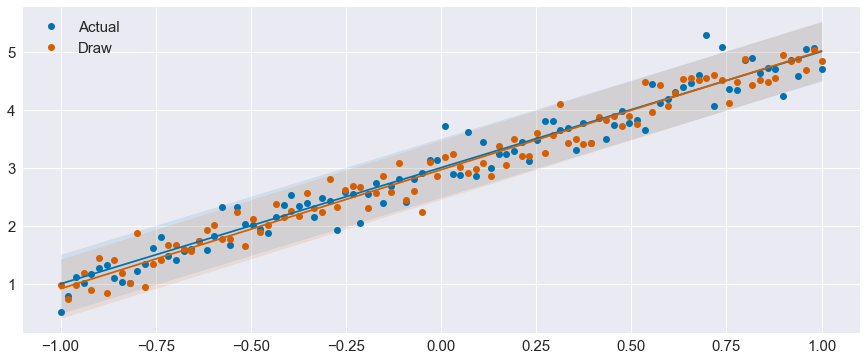

In [6]:
n_epochs_likelihood = 5000
batch_size_likelihood = 20
learning_rate = 0.01

likelihood_save_path, mse_l = train_likelihood(xs, ys, n_epochs_likelihood, batch_size_likelihood, learning_rate)
y_h, y_h_noise, slope, intercept, stdev, mse = predict_likelihood(xs, ys, likelihood_save_path)

results = np.round([slope, intercept, stdev, mse], 3)
print()
print(f'Slope: {results[0]} (actual is 2)')
print(f'Intercept: {results[1]} (actual is 3)')
print(f'Sigma: {results[2]} (actual is 0.25)')
print(f'Mean squared error: {results[3]}')
print()

plot_results(xs, y, ys, y_h, y_h_noise, stdev)